# Steam Platformu İçin Öneri Sistemi Geliştirmek

#### Gerekili Kütüphanelerin İnport Edilmesi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import time
from datetime import datetime

pd.set_option("display.max_rows", None, "display.max_columns", None) #Çıktı satırlarının tümünün gösterilmesini sağlar 

In [2]:
pStart = datetime.now().strftime('%H:%M:%S') 

#### User to İndex Fonksiyonu

In [3]:
#User ID listesini İndex listesine dönüştürmek için forksiyon
def index_list (user_id):
    index_list = []
    for user in user_id:
        index_keep = df.index[df.user == user ]
        index_list.extend(index_keep)
    return index_list

#### Kullanıcı statisticsleri Fonksiyonu

In [4]:
def UserStatistics (df):
    """
    Oluşturduğumuz user_statistics DataFrame'ine kullancıların statisticslerini depoluyoruz
    """
    user_statistics = pd.DataFrame(columns = ["zero_len", 
                                "played_len", 
                                "played_medyan", 
                                "played_mean", 
                                "played_max", 
                                "played_min",
                                "user_id"])
    for user in df.user.unique():
        keep = df.playtime_forever[df.user == user ]
        zero_len_keep = len(keep [keep==0])
        played_len_keep = len(keep [keep!=0])
        played_medyan_keep = keep [keep!=0].median()
        played_mean_keep = keep [keep!=0].mean()
        played_max_keep = keep [keep!=0].max()
        played_min_keep = keep [keep!=0].min()
        
        dictionary = {"zero_len": zero_len_keep, 
                      "played_len": played_len_keep, 
                      "played_medyan": played_medyan_keep, 
                      "played_mean": played_mean_keep, 
                      "played_max": played_max_keep, 
                      "played_min": played_min_keep,
                      "user_id": user} 
        df1 = pd.DataFrame(dictionary,index=[0])
        user_statistics = pd.concat([user_statistics,df1], axis=0,ignore_index=bool)
    return user_statistics       

#### Veri Setinin Yüklenmesi

In [5]:
df = pd.read_json('..\SteamData\SteamGameTime_raw.json')


## Veri Setine İlk bakış

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3877976 entries, 0 to 3877975
Data columns (total 7 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   appid                     int64  
 1   playtime_forever          int64  
 2   playtime_windows_forever  int64  
 3   playtime_mac_forever      int64  
 4   playtime_linux_forever    int64  
 5   user                      int64  
 6   playtime_2weeks           float64
dtypes: float64(1), int64(6)
memory usage: 236.7 MB


In [7]:
df.columns #Verinin değşkenleri

Index(['appid', 'playtime_forever', 'playtime_windows_forever',
       'playtime_mac_forever', 'playtime_linux_forever', 'user',
       'playtime_2weeks'],
      dtype='object')

In [8]:
df.head(10) #Veriye genel bakış

,appid,playtime_forever,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,user,playtime_2weeks
0,620,76,76,0,0,76561198258109920,NaN
1,261550,2885,2885,0,0,76561198258109920,NaN
2,255710,1061,642,0,0,76561198258109920,NaN
3,381210,498,498,0,0,76561198258109920,NaN
4,289070,211,211,0,0,76561198258109920,NaN
5,730,0,0,0,0,76561198258109920,NaN
6,1097150,158,158,0,0,76561198258109920,NaN
7,55100,0,0,0,0,76561198820816240,NaN
8,55150,0,0,0,0,76561198820816240,NaN
9,67370,0,0,0,0,76561198820816240,NaN


Veri setinde 7 değişken bulunmakta. User ve Appid değişkenleri katagorik geri kalan değişkendel sürekli değişken.
Değişken isimleri ve açıklamaları:
 * **appid**                     = Oyunun ID'si
 * **playtime_forever**          = Oyunun oynanma süresi (Dakika cinsinden)
 * **playtime_windows_forever**  = Oyunun Windows'ta oynanma süresi (Dakika cinsinden)
 * **playtime_mac_forever**      = Oyunun Mac'te oynanma süresi (Dakika cinsinden)
 * **playtime_linux_forever**    = Oyunun Linux'ta oynanma süresi (Dakika cinsinden)
 * **user**                      = Ounun sahibi olan kişinin ID'si
 * **playtime_2weeks**           = Oyunun son iki haftada oynanma süresi (Dakika cinsinden)

In [9]:
print("Satır sayısı = ",len(df.user)) #Satır sayısı
print("Benzersiz kullanıcı sayısı = ",len(df.user.unique())) #Benzersiz kullanıcı sayısı
print("Benzersiz oyun sayısı = ",len(df.appid.unique()))

Satır sayısı =  3877976
Benzersiz kullanıcı sayısı =  21127
Benzersiz oyun sayısı =  27107


## Veri Temizleme

#### Tekrar Ediler Satırların Silinmesi.

Veri Steam Api ile belirlikli aralıklar ile çekildiği için tekrar çekilen kullanıcıların temizlenmesi gerekmekte. 

In [10]:
df = pd.read_json ('..\SteamData\SteamGameTime_raw.json') 
df_checkpoints = df.copy() #Kıyaslamak için checkpointsliyoruz
df.drop_duplicates (keep = "first", inplace = True) #Tekrar eden satırlardan ilk olanı keepup geri kalanını siliyor

In [11]:
print("*Satır sayısı checkpoints = ",len(df_checkpoints))
print("*Satır sayısı = ",len(df))
print(" Silinen satır sayısı = ",len(df_checkpoints) - len(df))
print("*Benzersiz kullanıcı sayısı checkpoints = ",len(df_checkpoints.user.unique()))
print("*Benzersiz kullanıcı sayısı = ",len(df.user.unique()))
print(" Eksilen benzersiz kullanıcı sayısı = ",len(df_checkpoints.user.unique()) - len(df.user.unique()))

*Satır sayısı checkpoints =  3877976
*Satır sayısı =  3670344
 Silinen satır sayısı =  207632
*Benzersiz kullanıcı sayısı checkpoints =  21127
*Benzersiz kullanıcı sayısı =  21127
 Eksilen benzersiz kullanıcı sayısı =  0


Veri setinde playtime_windows_forever , playtime_mac_forever, playtime_linux_forever değişkenlerinin toplamı playtime_forever değişkenini vermelidir. Fakat bir çok gözlemde bu değeri bulamadığımızdan dolayı verinin toplanma işleminde hatalar olduğunu var sayabiliriz.

#### Kullanılamayan Sütunların Silinmesi.

In [12]:
l = ['playtime_windows_forever','playtime_mac_forever','playtime_linux_forever'] #Sütunların silinmesi
df = df.drop(l , axis = 1)
df.to_json('..\SteamData\SteamGameTime_clear.json', index = bool ) #Veriyi yeni bir data fream olarak yazdırıyoruz.

In [13]:
df.columns

Index(['appid', 'playtime_forever', 'user', 'playtime_2weeks'], dtype='object')

In [14]:
df.head(10)

,appid,playtime_forever,user,playtime_2weeks
0,620,76,76561198258109920,NaN
1,261550,2885,76561198258109920,NaN
2,255710,1061,76561198258109920,NaN
3,381210,498,76561198258109920,NaN
4,289070,211,76561198258109920,NaN
5,730,0,76561198258109920,NaN
6,1097150,158,76561198258109920,NaN
7,55100,0,76561198820816240,NaN
8,55150,0,76561198820816240,NaN
9,67370,0,76561198820816240,NaN


#### Kulanıcı İstatistiklerinin İncelenmesi

In [15]:
user_statistics = UserStatistics(df) #UserStatistics fonksiyonunu kullanarak df verisinin kullanıcı verilerini oluşturuyoruz

KeyboardInterrupt: 

In [16]:
user_statistics.head(10)

,zero_len,played_len,played_medyan,played_mean,played_max,played_min,user_id
0,1,6,354.5,814.833333,2885,76,76561198258109920
1,215,0,NaN,NaN,NaN,NaN,76561198820816240
2,13,0,NaN,NaN,NaN,NaN,76561197960439456
3,317,0,NaN,NaN,NaN,NaN,76561198382390400
4,21,247,211.0,233.109312,455,140,76561198331301744
5,101,54,252.5,23341.259259,1245316,53,76561198165251664
6,31,2,2.0,2.000000,3,1,76561198390197920
7,80,128,211.5,2379.093750,69051,1,76561198434021952
8,9,50,275.5,5779.180000,143224,1,76561198317320752
9,31,157,99.0,2402.968153,197719,1,76561198320694240


##### User_statistics Kayıt Noktası

In [17]:
user_statistics.to_json(r'..\SteamData\User_statistics.json', index = bool )

In [18]:
user_statistics = pd.read_json (r'..\SteamData\User_statistics.json')
user_statistics.columns

Index(['zero_len', 'played_len', 'played_medyan', 'played_mean', 'played_max',
       'played_min', 'user_id'],
      dtype='object')

#### Sahip olduğu hiçbir oyunu oynamamış kullanıcıların silinmesi

In [19]:
print("Sahip olduğu oyunların hiçbiri oynamamış kişi sayısı= ",len(user_statistics[user_statistics.played_len == 0]))
zero_user_id = user_statistics.user_id[user_statistics.played_len == 0]
zero_user_id.head() #Sahip olduğu oyunların hiçbiri oynamamış kişilerin user id'leri

Sahip olduğu oyunların hiçbiri oynamamış kişi sayısı=  1680


1     76561198820816240
2     76561197960439456
3     76561198382390400
19    76561198124094192
25    76561198256946256
Name: user_id, dtype: int64

In [20]:
indexler = index_list(zero_user_id) #zero_user_id listesini index_list fonksyonu ile dönüştürmek

In [21]:
#Liste indexlerine göre satırların silinmesi 
df_checkpoints = df.copy()
df.drop(indexler, axis = 0, inplace = True)

In [22]:
print("*Satır sayısı checkpoints = ",len(df_checkpoints))
print("*Satır sayısı = ",len(df))
print(" Silinen satır sayısı = ",len(df_checkpoints) - len(df))
print("*Benzersiz kullanıcı sayısı checkpoints = ",len(df_checkpoints.user.unique()))
print("*Benzersiz kullanıcı sayısı = ",len(df.user.unique()))
print(" Eksilen benzersiz kullanıcı sayısı = ",len(df_checkpoints.user.unique()) - len(df.user.unique()))

*Satır sayısı checkpoints =  3670344
*Satır sayısı =  3316888
 Silinen satır sayısı =  353456
*Benzersiz kullanıcı sayısı checkpoints =  21127
*Benzersiz kullanıcı sayısı =  19447
 Eksilen benzersiz kullanıcı sayısı =  1680


##### SteamGameTime_clear Kayıt Noktası

In [23]:
df.to_json(r'..\SteamData\SteamGameTime_clear.json', index = bool )

In [24]:
df = pd.read_json (r'..\SteamData\SteamGameTime_clear.json')  #Bu işlemi tekrar tekrar yapmamak kodu raw yaptım direk kayıttan çekiyoruz

#### Sahip oldukları oyun sayısı bakımından aykırı değerlerin temizlenmesi

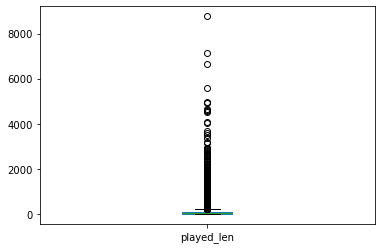

In [25]:
user_statistics.played_len.plot.box();

Yukarıda da görüldüğü gibi veri satinde çok sayıda aykırı gözlem bulunmakta.

In [26]:
Q1 = user_statistics.played_len.quantile(0.25) # 1. kartil
Q3 = user_statistics.played_len.quantile(0.75) # 2. kartil
IQR = Q3-Q1 # Çeyrek açıklık
lower = Q1- 1.5*IQR #Alt sınır değeri
upper = Q3 + 1.5*IQR #Üst sınır değeri
print("Alt aykırı değer sınırı= " ,lower)
print("Üst aykırı değer sınırı= " ,upper)

Alt aykırı değer sınırı=  -97.0
Üst aykırı değer sınırı=  207.0


In [27]:
id_list = user_statistics.user_id[user_statistics.played_len>upper] #Aykırı değerlerin veri seti içinde tesbit edilmesi
indexler = index_list(id_list)

In [28]:
print("*Oyun sayısı aykırı olan benzersiz kullanıcı sayısı = ",len(id_list))
print("*Oyun sayısı aykırı olan benzersiz kullanıcıların satır sayısı = ",len(indexler))

*Oyun sayısı aykırı olan benzersiz kullanıcı sayısı =  1622
*Oyun sayısı aykırı olan benzersiz kullanıcıların satır sayısı =  1551470


In [29]:
df_checkpoints = df.copy()
df.drop(indexler, axis = 0, inplace = True) #Aykırı değerlerin temizlenmesi

In [30]:
print("*Satır sayısı checkpoints = ",len(df_checkpoints))
print("*Satır sayısı = ",len(df))
print(" Silinen satır sayısı = ",len(df_checkpoints) - len(df))
print("*Benzersiz kullanıcı sayısı checkpoints = ",len(df_checkpoints.user.unique()))
print("*Benzersiz kullanıcı sayısı = ",len(df.user.unique()))
print(" Eksilen benzersiz kullanıcı sayısı = ",len(df_checkpoints.user.unique()) - len(df.user.unique()))

*Satır sayısı checkpoints =  3316888
*Satır sayısı =  1765418
 Silinen satır sayısı =  1551470
*Benzersiz kullanıcı sayısı checkpoints =  19447
*Benzersiz kullanıcı sayısı =  17825
 Eksilen benzersiz kullanıcı sayısı =  1622


In [31]:
user_statistics = UserStatistics(df)

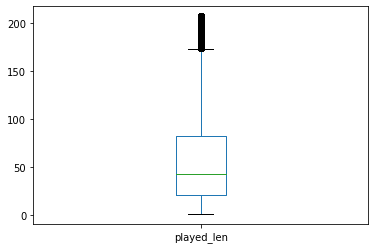

In [32]:
user_statistics.played_len.plot.box();

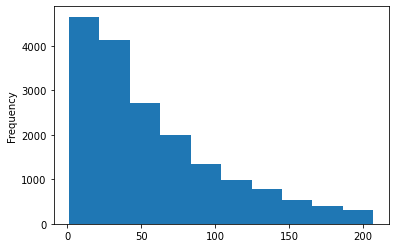

In [33]:
user_statistics.played_len.plot.hist();

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1765418 entries, 0 to 3877975
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   appid             int64  
 1   playtime_forever  int64  
 2   user              int64  
 3   playtime_2weeks   float64
dtypes: float64(1), int64(3)
memory usage: 67.3 MB


In [35]:
x = df.playtime_forever[df.appid == 550]

<AxesSubplot:>

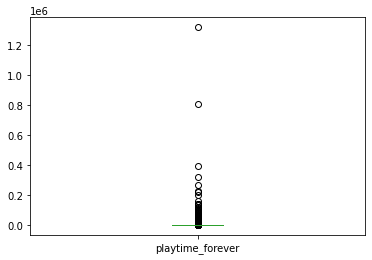

In [36]:
df.playtime_forever[df.appid == 550].plot.box()

#### Son Kayıt Noktası

In [37]:
df.to_json(r'..\SteamData\SteamGameTime_clear.json', index = bool )
user_statistics.to_json(r'..\SteamData\User_statistics.json', index = bool )

In [38]:
pStop = datetime.now().strftime('%H:%M:%S') 
print (pStart)
print (pStop)

18:10:05
18:21:47
